# Eyesense

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

-Normal (N),
-Diabetes (D),
-Glaucoma (G),
-Cataract (C),
-Age related Macular Degeneration (A),
-Hypertension (H),
-Pathological Myopia (M)

Source: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k/data

In [37]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
from shutil import copy, move

import cv2
from PIL import Image, ImageEnhance

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow import losses
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

## Dataset analysis

### General information about the data

In [7]:
df = pd.read_csv("/Users/erika/code/caazzi/eyesense/raw_data/ocular-disease-recognition-odir5k/full_df.csv")

In [3]:
df.describe()

,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<br>The dataset has **6392** entries of pictures and diagnosis and **4784** indicating that not all patients have pictures for both eyes.</br>
<br>The ages vary between 1 and 91 years old.</br>

In [4]:
df.sort_values("ID").head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg
3195,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_left.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3196,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3_left.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
3197,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",4_left.jpg
3198,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_left.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

> There are no null values in the DataFrame.

In [49]:
left = 0
right = 0
for row in df["filename"]:
    if "right" in row:
        right += 1
    if "left" in row:
        left += 1

print(f"Number of images of the right eye {right}")
print(f"Number of images of the left eye {left}")

Number of images of the right eye 3194
Number of images of the left eye 3198


### Data distribution plots

In [6]:
df["Patient Sex"].value_counts()

Patient Sex
Male      3424
Female    2968
Name: count, dtype: int64

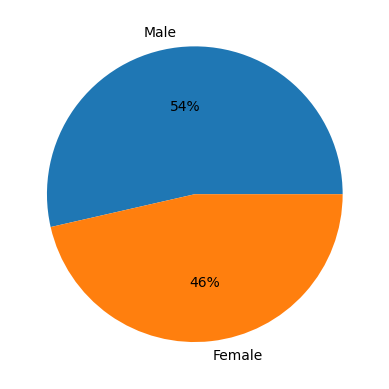

In [7]:
plt.pie(df["Patient Sex"].value_counts(), labels=['Male', 'Female'] ,autopct='%.0f%%')
plt.show()

> The majority of the patients were male.

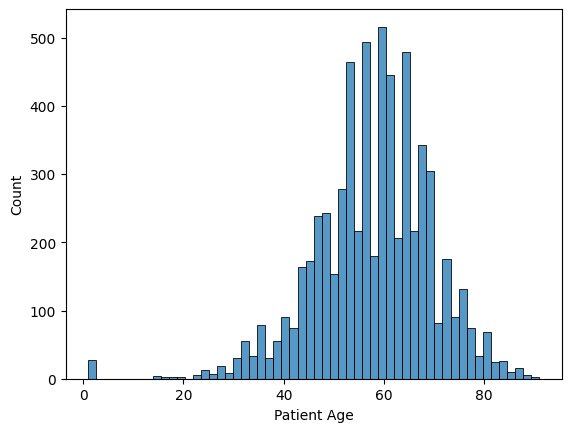

In [8]:
sns.histplot(df["Patient Age"]);

> The patient age was aproximately a normal distribution, centered at ~60 years. There are a few patients of 1 year old.

In [9]:
df['labels'].value_counts()

labels
['N']    2873
['D']    1608
['O']     708
['C']     293
['G']     284
['A']     266
['M']     232
['H']     128
Name: count, dtype: int64

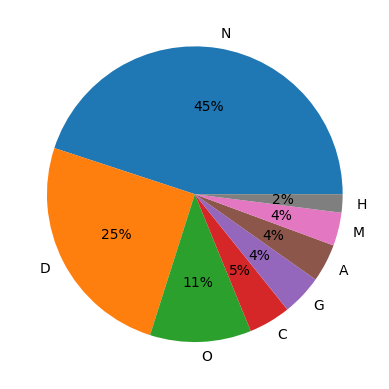

In [10]:
plt.pie(df['labels'].value_counts(), labels=['N', 'D', 'O', 'C', 'G', 'A', 'M', 'H'] ,autopct='%.0f%%')
plt.show()

> The major class is "Normal", thus if our model classifies all the images as "N", our baseline accuracy will be 45%

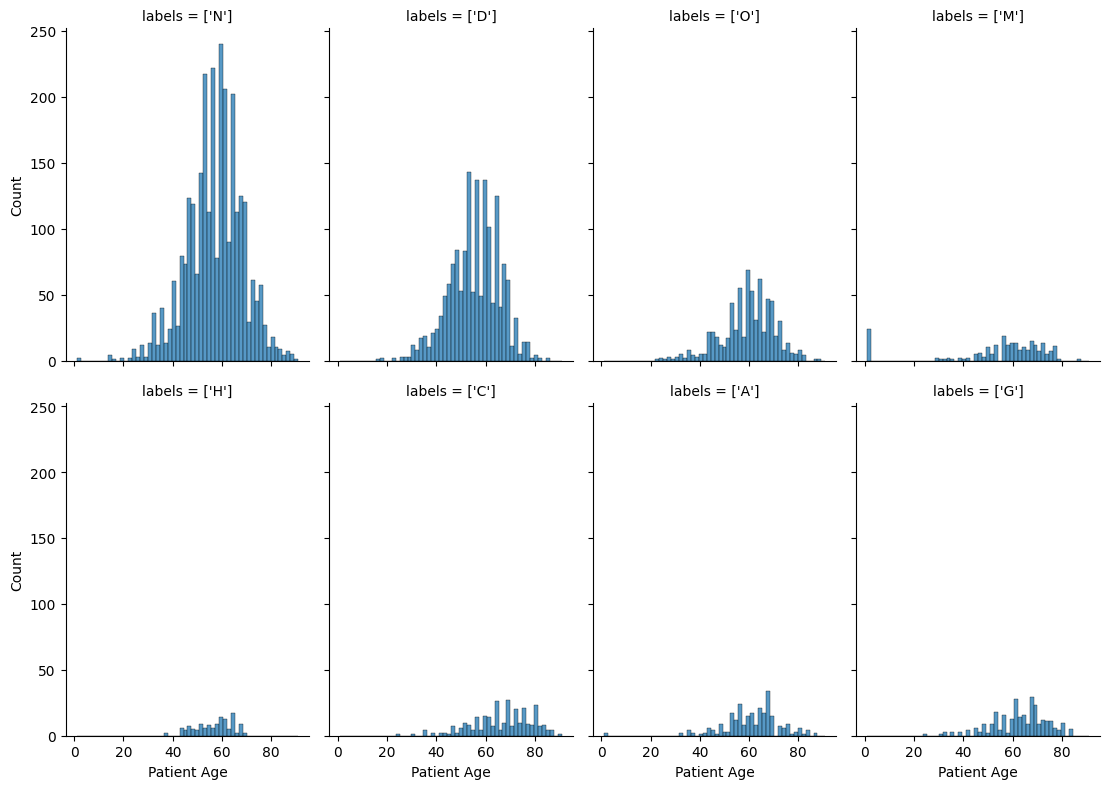

In [11]:
sns.displot(df, x="Patient Age", col="labels", height=4, aspect=.7, col_wrap=4);

In [12]:
df[df['Patient Age'] <= 15].groupby("Patient Age")["labels"].value_counts()

Patient Age  labels
1            ['M']     24
             ['A']      2
             ['N']      2
14           ['N']      2
15           ['N']      2
Name: count, dtype: int64

> The most common diseases in patients with age smaller than 15 is Pathological Myopia (M).

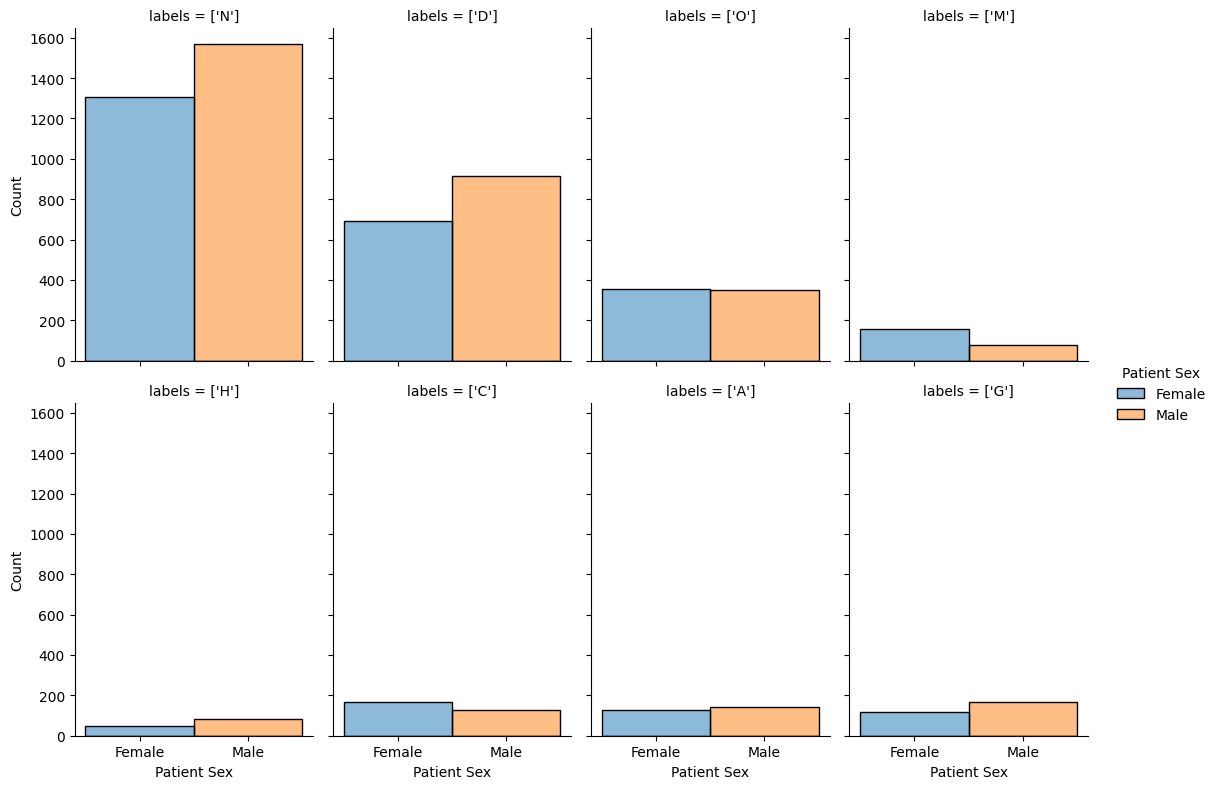

In [13]:
sns.displot(df, x="Patient Sex", col="labels", hue="Patient Sex", height=4, aspect=.7, col_wrap=4)

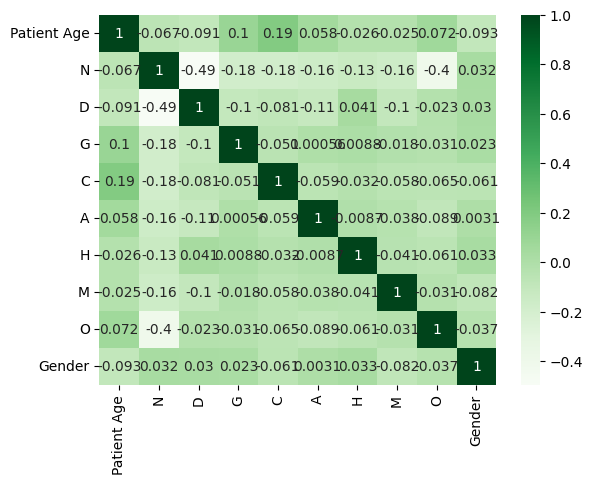

In [14]:
df["Gender"] = LabelEncoder().fit_transform(df["Patient Sex"])

matrix = df.select_dtypes(include=[np.number]).drop(columns='ID').corr()
sns.heatmap(matrix, cmap="Greens", annot=True);
df=df.drop(columns='Gender')

> The biggest correlations found were between the patient's age and Cataract, Glaucoma.

## Images organization and augmentation

### Image organization

In [64]:
# Gets the path to the raw data and creates a list with the image names

dir_path = os.path.join(os.getcwd(), 'raw_data', 'ocular-disease-recognition-odir5k', 'preprocessed_images')
img_list = os.listdir(dir_path)

In [65]:
# Creates the folders necessary to organize the images in different folders according to their classification

if os.path.isdir('data_train/normal') is False:
    os.makedirs('data_train/normal')
    os.makedirs('data_train/diabets')
    os.makedirs('data_train/glaucoma')
    os.makedirs('data_train/cataract')
    os.makedirs('data_train/degeneration')
    os.makedirs('data_train/hypertension')
    os.makedirs('data_train/myopia')
    os.makedirs('data_train/others')

In [66]:
# Creates the folders necessary for test
if os.path.isdir('data_test/normal') is False:
    os.makedirs('data_test/normal')
    os.makedirs('data_test/diabets')
    os.makedirs('data_test/glaucoma')
    os.makedirs('data_test/cataract')
    os.makedirs('data_test/degeneration')
    os.makedirs('data_test/hypertension')
    os.makedirs('data_test/myopia')
    os.makedirs('data_test/others')

In [67]:
# Creates the folders necessary for validation
if os.path.isdir('data_val/normal') is False:
    os.makedirs('data_val/normal')
    os.makedirs('data_val/diabets')
    os.makedirs('data_val/glaucoma')
    os.makedirs('data_val/cataract')
    os.makedirs('data_val/degeneration')
    os.makedirs('data_val/hypertension')
    os.makedirs('data_val/myopia')
    os.makedirs('data_val/others')

In [68]:
if len(os.listdir('data_train/normal')) == 0:  # Check if the directory is empty


    # Copies the training images in the corresponding directory according to the dataframe classification
    
    for file in df.filename[df.labels == "['N']"]:
        copy(os.path.join(dir_path, file) , 'data_train/normal')
    for file in df.filename[df.labels == "['D']"]:
        copy(os.path.join(dir_path, file) , 'data_train/diabets')
    for file in df.filename[df.labels == "['G']"]:
        copy(os.path.join(dir_path, file) , 'data_train/glaucoma')
    for file in df.filename[df.labels == "['C']"]:
        copy(os.path.join(dir_path, file) , 'data_train/cataract')
    for file in df.filename[df.labels == "['A']"]:
        copy(os.path.join(dir_path, file) , 'data_train/degeneration')
    for file in df.filename[df.labels == "['H']"]:
        copy(os.path.join(dir_path, file) , 'data_train/hypertension')
    for file in df.filename[df.labels == "['M']"]:
        copy(os.path.join(dir_path, file) , 'data_train/myopia')
    for file in df.filename[df.labels == "['O']"]:
        copy(os.path.join(dir_path, file) , 'data_train/others')

else:
    print("The directory 'data_train/normal' is not empty")
    print(f"\nProbably the files from {dir_path} were already copied into 'data_train/normal'.")

In [69]:
train_dir = os.path.join(os.getcwd(), 'data_train')
test_dir = os.path.join(os.getcwd(), 'data_test')
val_dir = os.path.join(os.getcwd(), 'data_val')

In [70]:
# Ensure test and validation directories exist
for base_dir in [test_dir, val_dir]:
    for subdir in os.listdir(train_dir):
        os.makedirs(os.path.join(base_dir, subdir), exist_ok=True)

# Move files: 10% for test, 20% for validation
for subdir in os.listdir(train_dir):
    source_path = os.path.join(train_dir, subdir)
    test_dest = os.path.join(test_dir, subdir)
    val_dest = os.path.join(val_dir, subdir)

    if len(os.listdir(test_dest)) == 0 and len(os.listdir(val_dest)) == 0:
        files = os.listdir(source_path)
        n_test = int(0.1 * len(files))  # 10% for test
        n_val = int(0.2 * len(files))   # 20% for validation

        test_files = random.sample(files, n_test)
        remaining_files = [f for f in files if f not in test_files]
        val_files = random.sample(remaining_files, n_val)

        # Move test files using os.rename
        for file in test_files:
            os.rename(os.path.join(source_path, file), os.path.join(test_dest, file))

        # Move validation files using os.rename
        for file in val_files:
            os.rename(os.path.join(source_path, file), os.path.join(val_dest, file))

    else:
        print(f"⚠️ The test/validation directories for '{subdir}' are not empty.")
        print(f"   The files from {source_path} were probably already moved.")


In [71]:
train_length = sum(len([f for f in files if f.endswith('.jpg')]) for _, _, files in os.walk(train_dir))
test_length = sum(len([f for f in files if f.endswith('.jpg')]) for _, _, files in os.walk(test_dir))
val_length = sum(len([f for f in files if f.endswith('.jpg')]) for _, _, files in os.walk(val_dir))

print(f"Train: {train_length}")
print(f"Test:  {test_length}")
print(f"Val:  {val_length}")

Train: 4483
Test:  635
Val:  1274


### Image augmentation

In [72]:
def count_images_per_class(data_dir):
    """
    Conta o número de imagens em cada classe dentro do diretório.

    Args:
        data_dir (str): Caminho do diretório contendo as subpastas das classes.

    Returns:
        dict: Dicionário contendo {classe: número de imagens}.
    """
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))])
    return class_counts

def augment_fundus_image(image_path, output_dir):
    """
    Aplica data augmentation em uma imagem de fundo de olho e salva a imagem aumentada.

    Args:
        image_path (str): Caminho da imagem original.
        output_dir (str): Diretório onde a imagem aumentada será salva.
    """
    img = Image.open(image_path)
    filename, ext = os.path.splitext(os.path.basename(image_path))
    
    augmentations = [
        lambda img: img.rotate(random.uniform(-20, 20), resample=Image.BICUBIC),
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: ImageEnhance.Brightness(img).enhance(1.15),
        lambda img: ImageEnhance.Brightness(img).enhance(0.85),
        lambda img: ImageEnhance.Contrast(img).enhance(1.15),
        lambda img: Image.fromarray(cv2.GaussianBlur(np.array(img), (5, 5), 0)),
        lambda img: img.crop((10, 10, img.width-10, img.height-10)).resize(img.size, Image.BICUBIC),
        lambda img: img.resize((int(img.width * 1.1), int(img.height * 1.1)), Image.BICUBIC).crop(
            ((int(img.width * 1.1) - img.width) // 2, 
             (int(img.height * 1.1) - img.height) // 2, 
             img.width + (int(img.width * 1.1) - img.width) // 2, 
             img.height + (int(img.height * 1.1) - img.height) // 2)
        )
    ]
    
    aug_img = random.choice(augmentations)(img)
    aug_img.save(os.path.join(output_dir, f"{filename}_aug{random.randint(1000,9999)}{ext}"))

def balance_dataset(data_dir):
    """
    Equilibra o dataset aplicando data augmentation para as classes minoritárias até alcançar a classe majoritária.

    Args:
        data_dir (str): Caminho do diretório contendo as subpastas das classes.
    """
    class_counts = count_images_per_class(data_dir)
    max_count = max(class_counts.values())

    for class_name, count in class_counts.items():
        if count < max_count:
            class_dir = os.path.join(data_dir, class_name)
            images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))]
            images_needed = max_count - count

            while images_needed > 0:
                for image_path in images:
                    if images_needed <= 0:
                        break
                    augment_fundus_image(image_path, class_dir)
                    images_needed -= 1

In [73]:
# Balanceia o dataset
balance_dataset(train_dir)

# Verifica o novo número de imagens por classe
print(count_images_per_class(train_dir))

{'hypertension': 2009, 'cataract': 2012, 'glaucoma': 2011, 'diabets': 2012, 'others': 2012, 'normal': 2012, 'degeneration': 2011, 'myopia': 2010}


In [74]:
# Dictionary to store the image count per class
image_counts = {}

# Iterate through each subfolder in the training directory
for subdir, _, files in os.walk(train_dir):
    num_images = len([f for f in files if f.endswith('.jpg')])
    
    if num_images > 0:  # Avoid displaying empty directories
        class_name = os.path.basename(subdir)  # Class name (folder name)
        image_counts[class_name] = num_images

# Display the image count per class
for class_name, count in image_counts.items():
    print(f"📂 Class '{class_name}': {count} images")

# Total image count
total_images = sum(image_counts.values())
print(f"\n📊 Total number of images: {total_images}")

📂 Class 'hypertension': 2009 images
📂 Class 'cataract': 2012 images
📂 Class 'glaucoma': 2011 images
📂 Class 'diabets': 2012 images
📂 Class 'others': 2012 images
📂 Class 'normal': 2012 images
📂 Class 'degeneration': 2011 images
📂 Class 'myopia': 2010 images

📊 Total number of images: 16089


In [75]:
batch_size = 8
img_height = 256
img_width  = 256

In [76]:
train_ds = image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16089 files belonging to 8 classes.


In [77]:
val_ds = image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1274 files belonging to 8 classes.


In [78]:
class_names_train = train_ds.class_names
class_names_train

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal',
 'others']

In [79]:
class_names_val = val_ds.class_names
class_names_val

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal',
 'others']

## PCA

### Check-list

In [80]:
# Main directory for the images
path_augm = "data_train"

# Sets to store the verifications
sizes = set()  # Stores unique sizes of the images
modes = set()  # Stores the color modes (RGB, L, RGBA, etc.)
num_images = 0  # Counts the processed images

# Loops through all subfolders and archives
for root, _, files in os.walk(path_augm):
    for img_name in files:
        img_path = os.path.join(root, img_name)

        try:
            with Image.open(img_path) as img:
                sizes.add(img.size)  # Adiciona tamanho da imagem
                modes.add(img.mode)  # Adiciona modo de cor (ex: 'RGB', 'L')
                num_images += 1
        except Exception as e:
            print(f"Error opening {img_path}: {e}")

# Checks if all images are PCA-compatible
if len(sizes) > 1:
    print(f"🚨 Error: The images have different sizes: {sizes}")
    print("⚠️ All images need to have the same size for PCA.")
else:
    print(f"✅ All images have the same size: {list(sizes)[0]}")

if len(modes) > 1:
    print(f"🚨 Error: The images have different color modes: {modes}")
    print("⚠️ Converting all images to the same format might be necessary (e.g., RGB).")
else:
    print(f"✅ All images are in the same color mode: {list(modes)[0]}")

if num_images < 2:
    print("🚨 Error: Too few images found for PCA. More samples are needed.")
else:
    print(f"✅ Sufficient number of images: {num_images}")

✅ All images have the same size: (512, 512)
✅ All images are in the same color mode: RGB
✅ Sufficient number of images: 16089


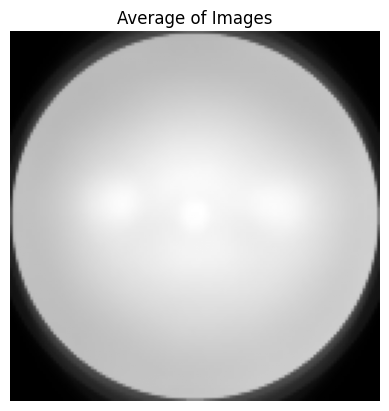

In [81]:
imgs = []

# Loops through all subfolders and files
for root, _, files in os.walk(path_augm):
    for img_name in files:
        img_path = os.path.join(root, img_name)
        
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            if img is None:
                print(f"⚠️ Error loading image: {img_path}")
                continue  # Skip corrupted or incompatible images
            
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size
            imgs.append(img)
        
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")

# Check if there are any images before calculating the mean
if len(imgs) == 0:
    print("🚨 No valid images found!")
else:
    # Calculate the mean of the images
    mean_img = np.mean(imgs, axis=0)

    # Display the mean image
    plt.imshow(mean_img, cmap='gray')
    plt.title("Average of Images")
    plt.axis("off")
    plt.show()


### Flattening and decomposing

In [83]:
import numpy as np
import tensorflow as tf

# Lists to store flattened images and labels
X_list = []
y_list = []

# Iterate over the dataset
for batch in train_ds:
    images, labels = batch  # Get the images and labels
    
    # Resize images to (256, 256)
    images = tf.image.resize(images, (img_height, img_width)).numpy()

    # Normalize images to [0,1]
    images = images / 255.0  

    # Flatten each image
    flattened_images = images.reshape(images.shape[0], -1)  
    
    X_list.append(flattened_images)
    y_list.append(labels.numpy())  # Convert labels to NumPy

# Convert lists to NumPy arrays
X_pca = np.vstack(X_list)  # Matrix of flattened images
y = np.concatenate(y_list)  # Corresponding labels vector

print(f"Shape of X_pca: {X_pca.shape}")  # Expected: (N_images, 256*256*3)
print(f"Shape of y: {y.shape}")  # Expected: (N_images,)
print(f"Unique classes: {np.unique(y)}")


2025-03-21 10:34:29.922158: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Shape of X_pca: (16089, 196608)
Shape of y: (16089,)
Unique classes: [0 1 2 3 4 5 6 7]


In [ ]:
pca = PCA(n_components=25) 
X_pca_model = pca.fit_transform(X_pca)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("PCA - Explained Variance by Components")

plt.show()

In [43]:
# Flattening and normalization of the validation images
# Lists to store flattened images and labels
X_list = []
y_list = []

# Iterate over the dataset
for batch in val_ds:
    images, labels = batch  # Get the images and labels
    
    images = images.numpy() / 255.0  # Normalize images to [0,1]
    flattened_images = images.reshape(images.shape[0], -1)  # Flatten each image
    
    X_list.append(flattened_images)
    y_list.append(labels.numpy())  # Convert labels to NumPy

# Convert lists to NumPy arrays
X_pca_val = np.vstack(X_list)  # Matrix of flattened images
y_val = np.concatenate(y_list)  # Corresponding labels vector

print(f"Shape of X_pca_val: {X_pca_val.shape}")  # (N_images, 196608)
print(f"Shape of y_val: {y_val.shape}")  # (N_images,)
print(f"Unique classes: {np.unique(y_val)}")  # Check available classes

Shape of X_pca_val: (636, 196608)
Shape of y_val: (636,)
Unique classes: [0 1 2 3 4 5 6 7]


2025-03-20 11:32:42.465778: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Naive model with KNN

### Cross-validate

In [44]:
acc_n = {}
for n in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=n)
    mean_acc = cross_val_score(knn, X=X_pca_model, y=y, scoring='accuracy', cv=5).mean()
    acc_n[n] = mean_acc

python(42871) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


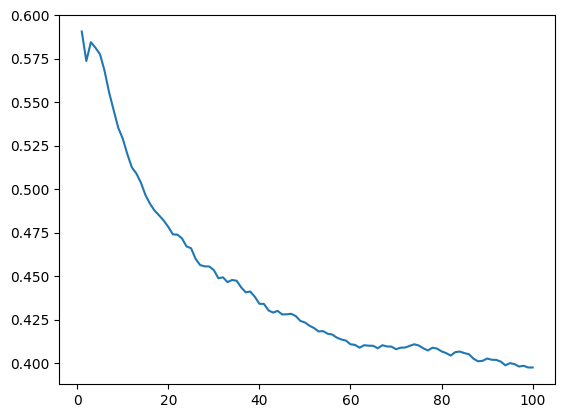

In [45]:
plt.plot(acc_n.keys(), acc_n.values());

### Hold-out

In [46]:
X_pca_model_val = pca.transform(X_pca_val)

In [47]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_pca_model, y)

KNeighborsClassifier(n_neighbors=1)

In [48]:
y_pred = knn.predict(X_pca_model_val)

### Metrics

In [49]:
# Calculate the metrics correctly for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Show results
print(f"The model's accuracy is: {accuracy}")
print(f"The model's precision is: {precision}")
print(f"The model's recall is: {recall}")
print(f"The F1 score is: {f1}")

The model's accuracy is: 0.3050314465408805
The model's precision is: 0.3652282987580978
The model's recall is: 0.3050314465408805
The F1 score is: 0.32019687180043815


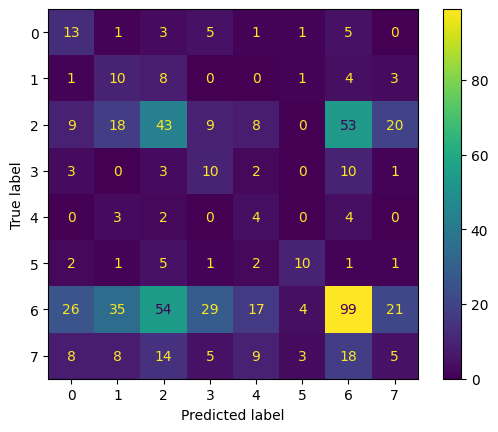

In [50]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## Naive model with Random Forest Classifier

### Cross-validate

In [ ]:
RFClass = RandomForestClassifier()
mean_acc = cross_val_score(RFClass, X=X_pca_model, y=y, scoring='accuracy', cv=5).mean()
mean_acc

### Hold-out

In [ ]:
RFClass.fit(X_pca_model, y)
y_pred = RFClass.predict(X_pca_model_val)

### Metrics

In [ ]:
# Calculate the metrics correctly for multiclass classification
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Show results
print(f"The model's accuracy is: {accuracy}")
print(f"The model's precision is: {precision}")
print(f"The model's recall is: {recall}")
print(f"The F1 score is: {f1}")

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

## CNN

In [41]:
def initialize_model():
    model = models.Sequential([
          tf.keras.layers.Rescaling(1./255),
          
          tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', 
                                 kernel_regularizer=regularizers.l2(0.001)),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.3),

          tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', 
                                 kernel_regularizer=regularizers.l2(0.001)),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.4),

          tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', 
                                 kernel_regularizer=regularizers.l2(0.001)),
          tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
          tf.keras.layers.Dropout(0.4),

          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(8, activation='softmax')
        ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    model.compile(
          optimizer=optimizer,
          loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics=['accuracy'])
    
    return model

In [42]:
model = initialize_model()

In [43]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [44]:
es = EarlyStopping(patience=5, restore_best_weights=True)

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

Epoch 1/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 562s 398ms/step - accuracy: 0.2467 - loss: 2.2025 - val_accuracy: 0.4027 - val_loss: 1.8396
Epoch 2/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 602s 427ms/step - accuracy: 0.3962 - loss: 1.7790 - val_accuracy: 0.4435 - val_loss: 1.7748
Epoch 3/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 634s 450ms/step - accuracy: 0.4827 - loss: 1.5619 - val_accuracy: 0.4419 - val_loss: 1.7556
Epoch 4/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 639s 454ms/step - accuracy: 0.5102 - loss: 1.4994 - val_accuracy: 0.4474 - val_loss: 1.7443
Epoch 5/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 629s 447ms/step - accuracy: 0.5308 - loss: 1.4420 - val_accuracy: 0.4505 - val_loss: 1.7123
Epoch 6/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 639s 454ms/step - accuracy: 0.5463 - loss: 1.4262 - val_accuracy: 0.4482 - val_loss: 1.7158
Epoch 7/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 628s 446ms/step - accuracy: 0.5489 - loss: 1.3993 - val_accuracy: 0.4443 - val_loss: 1.7092
Epoch 8/50
1408/1408 ━━━━━━━━━━━━━━━━━━━━ 628s 446ms/step - ac

KeyboardInterrupt: 

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.autoscale()
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.autoscale()
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history, exp_name= 'Optimized CNN model');

In [ ]:
test_ds = image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
y_pred = model.predict(test_ds)

In [ ]:
X_list = []
y_list = []

for images, labels in test_ds:
    X_list.append(images.numpy())  
    y_list.append(labels.numpy())  

X_test = np.concatenate(X_list, axis=0)
y_test = np.concatenate(y_list, axis=0)

print(f"Shape of X_test: {X_test.shape}")  # (N_imagens, img_height, img_width, 3)
print(f"Shape of y_test: {y_test.shape}")  # (N_imagens,)

### Metrics

In [ ]:
# Calculate the metrics correctly for multiclass classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Show results
print(f"The model's accuracy is: {accuracy}")
print(f"The model's precision is: {precision}")
print(f"The model's recall is: {recall}")
print(f"The F1 score is: {f1}")

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

## Resnet

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model
# Add custom layers for your classification task

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
output = layers.Dense(8, activation='softmax')(x)  # the number of your classes

model_resnet = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
model_resnet.compile(
    optimizer= optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 50,
    callbacks = [es],
    verbose = 1
)

In [ ]:
plot_history(history, exp_name= 'First Resnet model');

In [ ]:
y_pred = model_resnet.predict(test_ds)

### Metrics

In [ ]:
# Calculate the metrics correctly for multiclass classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Show results
print(f"The model's accuracy is: {accuracy}")
print(f"The model's precision is: {precision}")
print(f"The model's recall is: {recall}")
print(f"The F1 score is: {f1}")

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()